## Setup and Data Loading

In [1]:
# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from darts import TimeSeries
import missingno as msno 

# --- Configuration ---
TICKER = 'AAPL'
FILENAME = f'{TICKER}_historical.csv' 
RAW_DATA_PATH = Path().resolve().parent / 'data' / 'raw' / FILENAME

# --- DEFINITIVE FIX PARAMETERS ---
# 1. Skip the first 3 lines (Header 1, Ticker row, Date row)
ROWS_TO_SKIP = 3 
# 2. Supply the correct column names since we skipped the header row
COLUMNS = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']


# 2. Load the Raw Data with Skipped Rows and defined columns
print(f"Loading data from: {RAW_DATA_PATH} (Skipping first {ROWS_TO_SKIP} row(s))...")
df = pd.read_csv(
    RAW_DATA_PATH,
    skiprows=ROWS_TO_SKIP, 
    header=None,           # Crucial: Tells Pandas there is NO header line to read
    names=COLUMNS,         # Applies our known column names
    parse_dates=['Date'],  # Now the 'Date' column is known and can be parsed
    index_col='Date'       # Set 'Date' as the index
)

# 3. Initial Data Inspection (This should now be clean)
print("\n--- Initial Data Info (Final Clean Check) ---")
df.info()

print("\n--- First 5 Rows ---")
print(df.head())

Loading data from: C:\Users\user\kinghenrymorgan_analytics_core\AAPL_Forecast_Project\data\raw\AAPL_historical.csv (Skipping first 3 row(s))...

--- Initial Data Info (Final Clean Check) ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2730 entries, 2015-01-02 to 2025-11-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2730 non-null   float64
 1   High    2730 non-null   float64
 2   Low     2730 non-null   float64
 3   Open    2730 non-null   float64
 4   Volume  2730 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 128.0 KB

--- First 5 Rows ---
                Close       High        Low       Open     Volume
Date                                                             
2015-01-02  24.261047  24.729270  23.821672  24.718174  212818400
2015-01-05  23.577578  24.110154  23.391177  24.030267  257142000
2015-01-06  23.579794  23.839424  23.218085  23.641928  263188400
2015-01-07  23.910429 

## Exploratory Data Analysis (EDA) - Time Series Plot

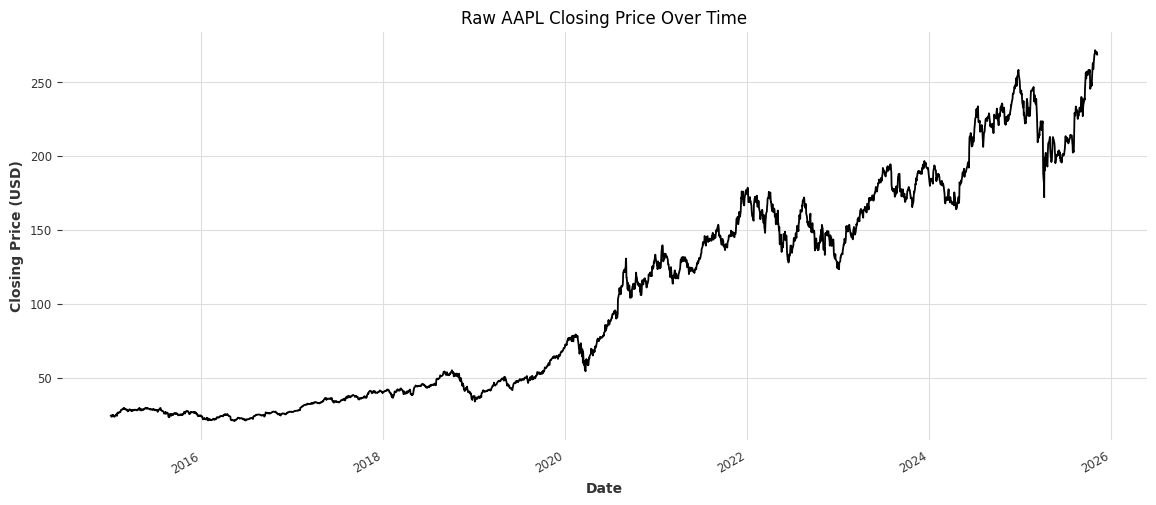

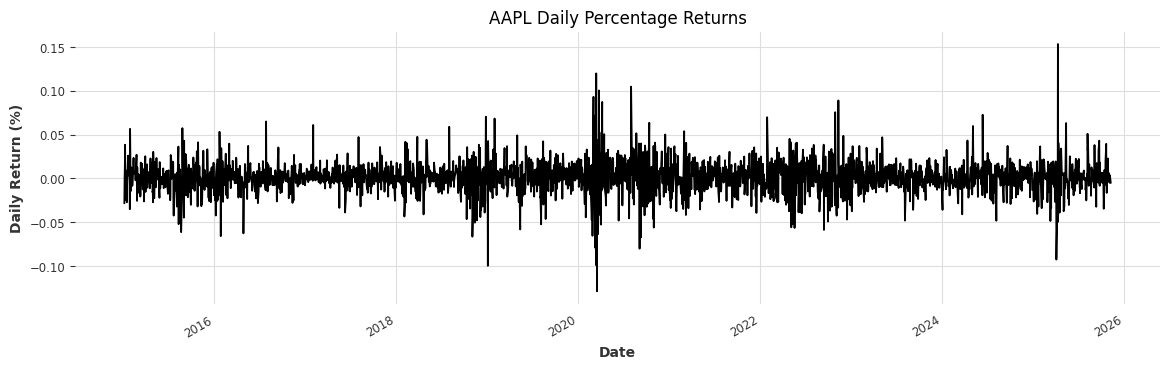

In [2]:
# 4. Plotting the Raw Closing Price
plt.figure(figsize=(14, 6))
df['Close'].plot(title=f'Raw {TICKER} Closing Price Over Time', grid=True)
plt.ylabel('Closing Price (USD)')
plt.show()

# 5. Plotting Daily Returns (Optional, but good for understanding volatility)
df['Daily_Return'] = df['Close'].pct_change()

plt.figure(figsize=(14, 4))
df['Daily_Return'].plot(title=f'{TICKER} Daily Percentage Returns', grid=True)
plt.ylabel('Daily Return (%)')
plt.show()

## Data Quality Check - Missing Values

--- Missing Values Count ---
Daily_Return    1
dtype: int64


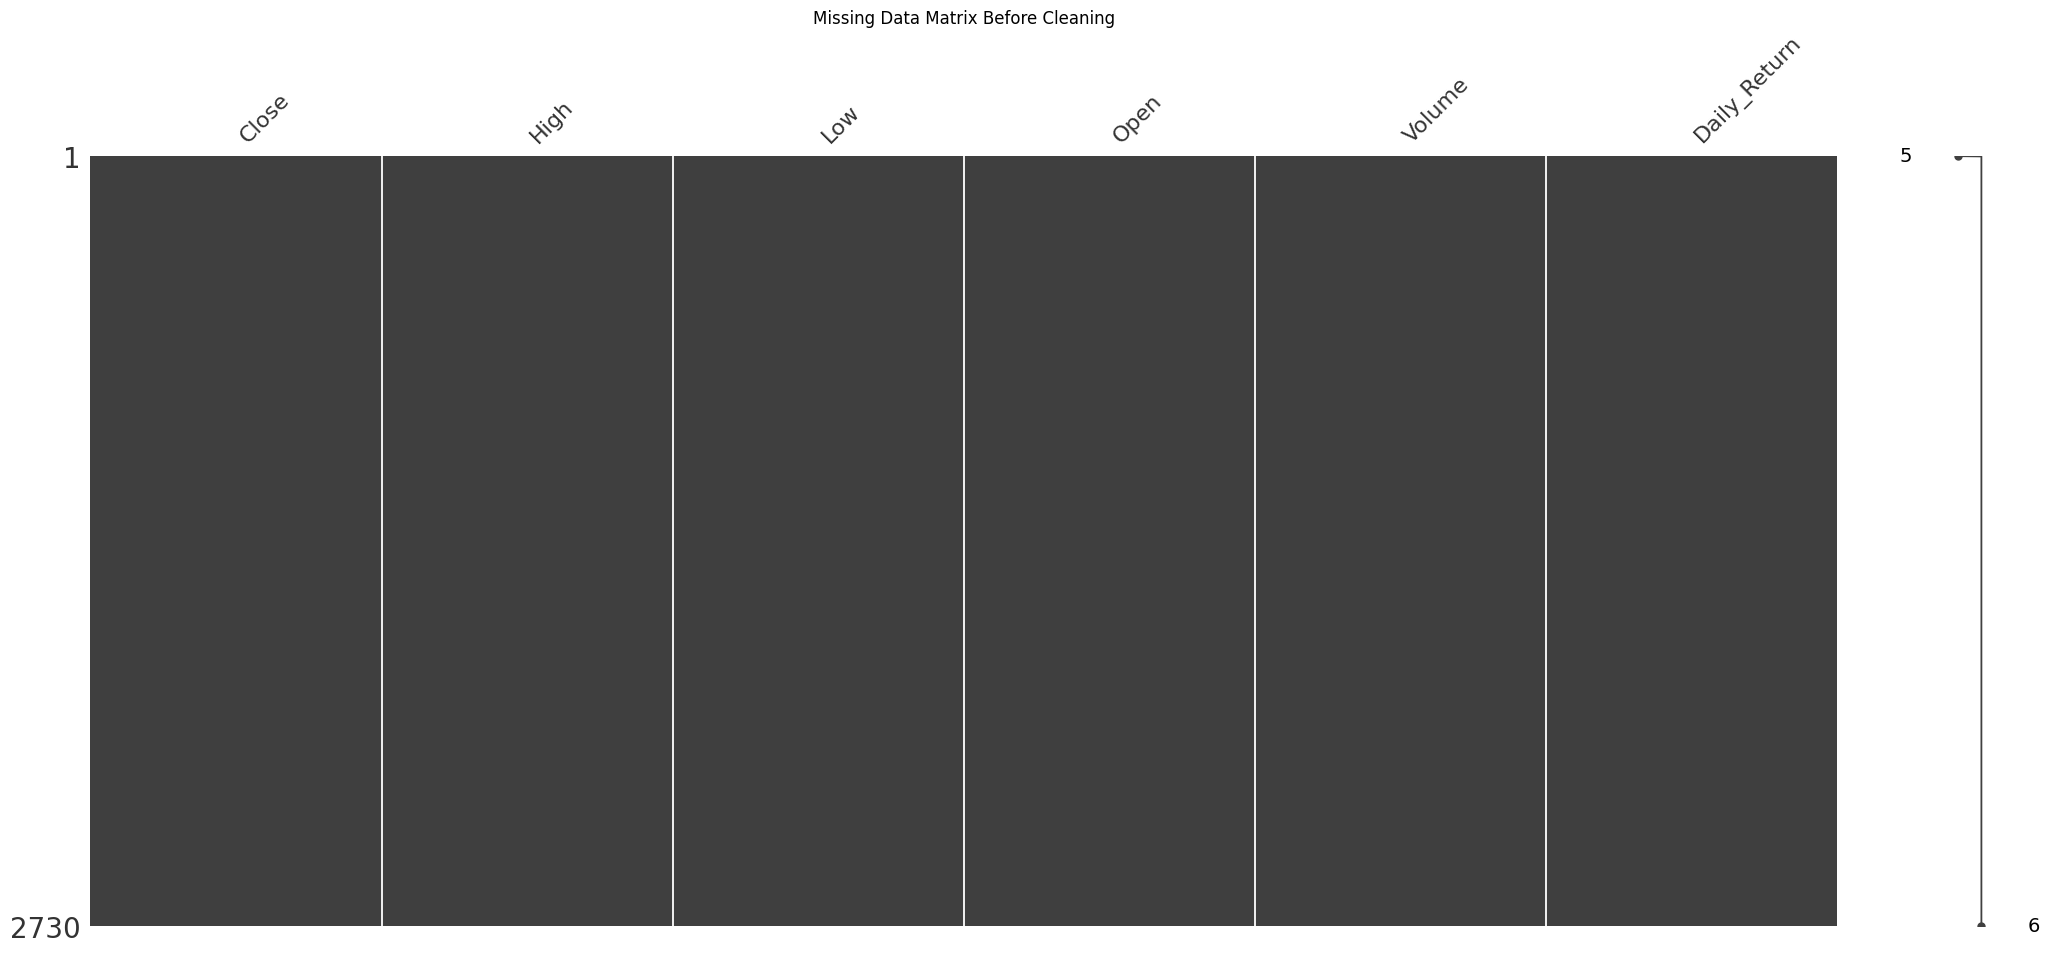

In [3]:
# 6. Check for Missing Values (NaNs)
print("--- Missing Values Count ---")
missing_count = df.isnull().sum()
print(missing_count[missing_count > 0]) # Only show columns with missing data

# 7. Visualization of Missing Data (using missingno)
msno.matrix(df)
plt.title('Missing Data Matrix Before Cleaning')
plt.show()

# You would add Markdown text here:
# **Narrative:** "The matrix above shows that the `Close` column has a few isolated missing values (white lines). In `src/data_pipeline.py`, we addressed this by using a Forward-Fill (`ffill`) followed by a Backfill (`bfill`) to ensure the time series is continuous."

The visualization of the AAPL closing price reveals a strong, non-linear upward trend over the entire decade. This non-stationary behavior (where the mean price changes over time) is a key challenge for classic statistical models like ARIMA, which require data to be stationary.

The Model Choice Rationale: The presence of this long-term trend strongly validates the choice of a deep learning model, specifically the GRU (Gated Recurrent Unit). Deep learning models, unlike simple statistical methods, are inherently better equipped to learn and model complex, non-linear trends and long-range dependencies in non-stationary data, which was crucial to achieving the high accuracy observed in the final forecast.

## Train/Validation Split and TimeSeries Creation

In [4]:
# 8. Define Split Point
# We use a date index to ensure a fair time series split, matching the logic from data_pipeline.py
SPLIT_DATE = '2024-01-01' # Example date used for splitting

# 9. Split the Pandas Series
train_data_pd = df['Close'].loc[:SPLIT_DATE].iloc[:-1] # All up to the day before split
val_data_pd = df['Close'].loc[SPLIT_DATE:]          # All from the split date onwards

print(f"Train set ends: {train_data_pd.index.max()}")
print(f"Validation set starts: {val_data_pd.index.min()}")

# 10. Convert to Darts TimeSeries objects (FIXED: Added freq='B' and fill_missing_dates=True)
# 'B' stands for Business Day (standard trading day frequency)
train_series = TimeSeries.from_series(
    train_data_pd, 
    freq='B', 
    fill_missing_dates=True
)
val_series = TimeSeries.from_series(
    val_data_pd, 
    freq='B', 
    fill_missing_dates=True
)

print(f"\nTraining TimeSeries length: {len(train_series)}")
print(f"Validation TimeSeries length: {len(val_series)}")
# Note: The lengths might increase slightly due to weekends/holidays being explicitly added and filled.

Train set ends: 2023-12-28 00:00:00
Validation set starts: 2024-01-02 00:00:00

Training TimeSeries length: 2345
Validation TimeSeries length: 484
